# PyTorch:  Neural Network for two classes - XOR

## Toy data

Consider a two-dimensional feature space. There are objects of two kinds (classification into two classes).<br>
Let's generate 1200 objects and draw them in the feature space.

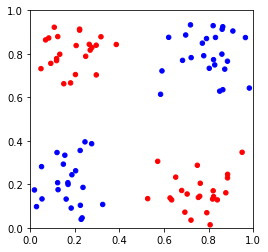

(100, 2) (100, 1)
torch.Size([100, 2]) torch.Size([100, 1])


In [109]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt                             
from   torchinfo    import summary 

num = 25

X1 = np.random.normal( [0.2,0.2], 0.1, (num,2));  Y1 = np.full((num,1), 0)   
X2 = np.random.normal( [0.8,0.2], 0.1, (num,2));  Y2 = np.full((num,1), 1)   
X3 = np.random.normal( [0.8,0.8], 0.1, (num,2));  Y3 = np.full((num,1), 0)   
X4 = np.random.normal( [0.2,0.8], 0.1, (num,2));  Y4 = np.full((num,1), 1)   
X = np.concatenate([X1,X2,X3,X4], axis=0);        Y  = np.concatenate([Y1,Y2,Y3,Y4], axis=0)
 
plt.figure (figsize=(4, 4), facecolor ='w')                                 
plt.scatter(X[:,0], X[:,1], c=Y[:,0],  s=20, cmap='bwr')        
plt.xlim(0, 1)
plt.ylim(0, 1);
plt.show()                                                  
print(X.shape, Y.shape)

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y.reshape(-1,1), dtype=torch.float32)

print(X.shape, Y.shape)

<div style="display:flex">
<div>
<h2> Layer Sequence </h2>
<p>
To solve the classification problem, we will create a neural network with two inputs (dimension of the feature space) and one output. If the output is 0, then we consider that this is the first class, and if the output is 1, then the second.
Let's create a neural network with one hidden layer with nH neurons.
</p>
<p>
For such a simple architecture in PyTorch, it is convenient to use the Sequential method inside which lists the layers and activation functions that apply to their outputs:</p>
</div>
<div>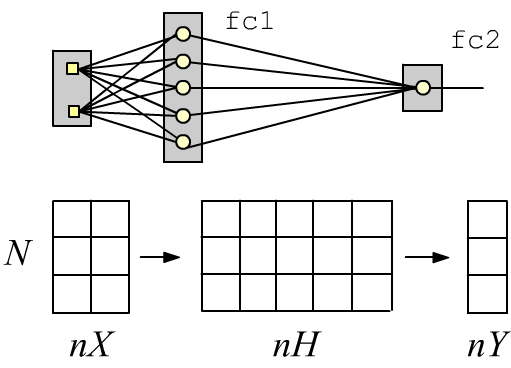<div>
</div>

In [110]:
class NN(nn.Module):
    def __init__(self, inputs=2, outputs=1, hiddens=[]):                                                      # Add output hidden layers
        super(NN, self).__init__()
        
        self.layers = []
        hiddens = [inputs] + hiddens + [outputs]
        for i in range(1, len(hiddens)):
            self.layers += [
                nn.Linear(hiddens[i-1], hiddens[i]), 
                nn.Sigmoid()
            ]
        
        self.model = nn.Sequential(*self.layers)                 
 
    def forward(self, x):               
        return self.model(x)

    def get(self, x):
        res = []
        for layer in self.layers:
            x = layer(x)
            res.append(x.data.cpu().numpy())
        return res
    
model = NN(2,1, [3])
print(model)
#summary(model, (1,2), col_names=["kernel_size", "output_size", "num_params"],) 

NN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=3, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


## Network learning

To train the network, you need to determine the loss function and the optimization method. For the loss function, we choose the Binary Cross Entropy (BCELoss).
The optimizer will be the gradient stochastic descent. It needs to pass model parameters and two hyperparameters.
The first parameter `lr` is the learning rate, and the second: `momentum` is the degree to which previous gradient values are taken into account (smoothing).

In [111]:
loss      = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.95 )

Let's define a function that shuffles the data. Then it breaks them into batches of size `batch_size`.
If the `train=True` parameter, then after calculating the loss, the model parameters are corrected.

In [91]:
def fit(model, X,Y, batch_size=32, train=True):    
    batch_size = min(batch_size, len(X))
    losses, accs = [], []                                # losses and  accuracies
                   
    idx = torch.randperm( len(X) )                       # permuted index list
    X, Y = X[idx], Y[idx]        
    
    model.train(train)                                   # important for Dropout, BatchNorm layers    
    for i in range(0, len(Y), batch_size):             
        nb = min(batch_size,  len(Y)-i)
        
        xb, yb = X[i: i+batch_size], Y[i: i+batch_size]  # current batch        
                      
        y = model(xb)                                    # forward propagation
        L = loss(y, yb)                                  # calculate the loss
  
        if train:                                        # we are in learning mode
            optimizer.zero_grad()                        # reset the gradients        
            L.backward()                                 # calculate gradients            
            optimizer.step()                             # adjusting parameters
                                     
        losses.append(L.item())                          
        accs.append(  (y.detach().round() == yb).float().mean() )
          
    return np.mean(losses),  np.mean(accs)              # mean error and accuracy

before:      loss: 0.0532 accuracy: 0.9922
epoch:  1000 loss: 0.0479 accuracy: 0.9922

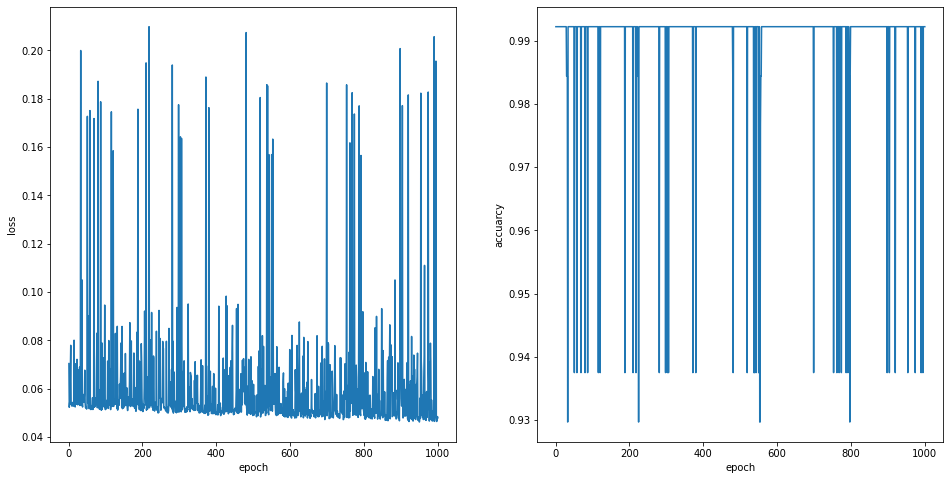

In [115]:
L, A = fit(model, X,Y, train=False)
print(f"before:      loss: {L:.4f} accuracy: {A:.4f}")
history = [] 
epochs = 1000                                            # number of epochs
for epoch in range(1,epochs+1):                          
    L,A = fit(model, X, Y)                               # one epoch
    history.append((epoch, L, A))
     
    if epoch % 100 == 0 or epoch == epochs:                 
        print(f'\repoch: {epoch:5d} loss: {L:.4f} accuracy: {A:.4f}', end="" ) 
    
history = np.array(history)                              # learning output
plt.figure(figsize=(16,8))              
plt.subplot(1, 2, 1); plt.plot(history[:,0], history[:, 1]); plt.xlabel('epoch'); plt.ylabel('loss')  
plt.subplot(1, 2, 2); plt.plot(history[:,0], history[:, 2]); plt.xlabel('epoch'); plt.ylabel('accuarcy')
plt.show()

## Hidden layer interpretation

NN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=2, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
(100, 2)
(100, 2)
(100, 1)
(100, 1)
(100, 2) (100,)


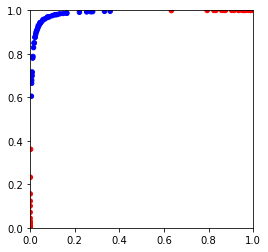

torch.Size([100, 2]) torch.Size([100, 1])


In [58]:
print(model)
res = model.get(X)
for r in res:
    print(r.shape)

x = res[1]    
y = Y.numpy().reshape(-1,)
print(x.shape, y.shape)

plt.figure (figsize=(4, 4), facecolor ='w')                                 
plt.scatter(x[:,0], x[:,1], c=y,  s=20, cmap='bwr')        
plt.xlim(0, 1)
plt.ylim(0, 1);
plt.show()                                                  
print(X.shape, Y.shape)    


(100, 3) (100,)


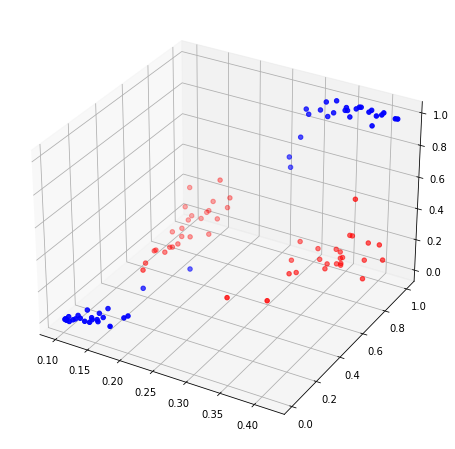

In [116]:
from mpl_toolkits.mplot3d import Axes3D

res = model.get(X)
x = res[1]    
y = Y.numpy().reshape(-1,)
print(x.shape, y.shape)


fig = plt.figure (figsize=(8, 8), facecolor ='w')       
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], c=y,  cmap='bwr')        
plt.show()                                                  

## Classification visualization

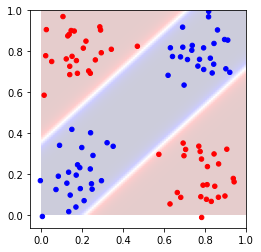

In [63]:
X_MIN, X_MAX, X_NUM = 0., 1., 100
Y_MIN, Y_MAX, Y_NUM = 0., 1., 100

x = np.linspace(X_MIN, X_MAX, X_NUM, dtype=np.float32)
y = np.linspace(Y_MIN, Y_MAX, Y_NUM, dtype=np.float32)
x, y =  np.meshgrid(x, y)    

inp = torch.cat([torch.tensor(x).view(-1,1), torch.tensor(y).view(-1,1)], 1)

z  = model(inp).detach().view(X_NUM, Y_NUM).numpy()
    
plt.figure(figsize=(4,4), facecolor ='w')
plt.imshow(z, extent=[X_MIN, X_MAX, Y_MIN, Y_MAX],  origin='lower', cmap='seismic', alpha=0.2)
plt.scatter(X.numpy()[:,0], X.numpy()[:,1], c=Y.numpy()[:,0],  s=20, cmap='bwr')        
plt.show()